# **Reinforecement Learning - Tic Tac Toe**


### Deep Q-learning

---

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd ./drive/My\ Drive/RL

Mounted at /content/drive
/content/drive/My Drive/RL


In [ ]:
from TicTacToe.TicTacToe import TicTacToeState, BOARD_DIM, N_CH
from Players.HumanPlayer import HumanPlayer
from Players.MaxminPlayer import MaxminPlayer
from Players.DQPlayer import DQPlayer, DQNArgs
from Players.RandomPlayer import RandomPlayer
from Players.SemiRandomPlayer import SemiRandomPlayer
from Utility.Auxiliary import *
%matplotlib inline

---
## **Learning**

We'll train our Deep Q-learning player in a few different settings, for the sake of the research and in order to find the best one for this task.  
Similar to the tabular Q-learning notebook, each training will show a running average of results of 100 games during the training.  
For evaluation, we'll test our player against 3 other players:
- 10,000 games against a random player.
- 1,000 games against a random minimax player, which randomly chooses between all the best actions for *k* turns ahead. We're using 1,000 since its calculation time is longer and also because it has a smaller action space (only the optimal actions).
- 2 games against himself - meaning an identical player (once starting first and once second). 2 games is enough because both players are deterministic so all games will end up the same.

We'll make ourselves a convinient evaluation function for the above, which will take advantage of the ```evaluate``` function.

In [ ]:
state = TicTacToeState()

# Evaluation function:
def multi_evaluation(state, player, opponents, nGamesList):
    N = len(opponents)
    pWin1 = [0] * N
    pWin2 = [0] * N
    pTie = [0] * N
    for i, (opp, nGames) in enumerate(zip(opponents, nGamesList)):
        pWin1[i], pWin2[i], pTie[i] = evaluate(state, player, opp, nGames)
    print()
    for i, (opp, nGames) in enumerate(zip(opponents, nGamesList)):
        print("{} vs. {}: P1 Win {:.2f}% | P2 Win {:.2f}% | Tie {:.2f}%".format(player.name, opp.name, pWin1[i] * 100,
                                                                                pWin2[i] * 100, pTie[i] * 100))

We'll initialize some training hyperparameters, some for the neural network itself, some for the training process, and some for the MDP:



In [ ]:
tictactoe_dqn_args = DQNArgs(ch=N_CH,                   # NN input channels - don't change this!
                             h=BOARD_DIM,               # NN input height - don't change this!
                             w=BOARD_DIM,               # NN input wodth - don't change this!
                             output_size=BOARD_DIM**2,  # NN output size (number of actions) - don't change this!
                             layer_channels=[64, 32],   # number of channels for each layer
                             layer_sizes=[3, 1],        # kernel sizes for each layer
                             layer_strides=[1, 1],      # stride for each layer
                             layer_padding=[0, 0],      # padding for each layer
                             batch_size=32,             # batch size for optimization step
                             mem_size=100000,           # replay memory size
                             target_update=5000,        # training step period for target network update
                             eps_decay=2e4,             # exploration rate decay
                             lr=0.001,                  # learning rate
                             gamma=0.99)                # MDP discount factor

### Learning against a random player:

We saw in the tabular Q-learning notebook that training against a random player actually achieved really good results, so we'll try it out with the deep Q-learning player as well.  
But as opposed to the tabular Q-learning method, the deep one is a function approximator, so it is harder to train. Knowing that, we'll spoil it with a few more learning steps: 150,000 instead of the previous 100,000.

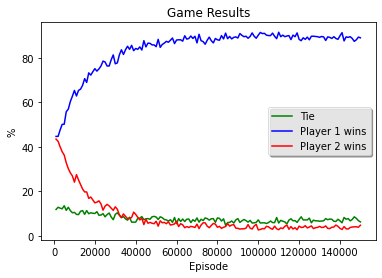

In [ ]:
policy_fileName = "./TicTacToe/DQpolicy_vsRand"
nGames = 150000

p1 = DQPlayer("DQ", tictactoe_dqn_args, isLearning=True)
p2 = RandomPlayer("Random")

log = train(state, p1, p2, nGames=nGames)
plot_log(log)
p1.save_policy(policy_fileName)

We can see that our player started out with the same amount of wins and losses, which makes sense since it behaves as a random player at the beginning. Slowly, our player learns from experience, and also increases the exploitation rate - so it gradually improves.

Now let's test our player...

In [ ]:
policy_fileName = "./TicTacToe/DQpolicy_vsRand"
p1 = DQPlayer("DQ", tictactoe_dqn_args, isLearning=False)
p1.load_policy(policy_fileName)

p2 = RandomPlayer("Random")
p3 = MaxminPlayer("Minimax", max_depth=4)
p4 = DQPlayer("DQ2", tictactoe_dqn_args, isLearning=False)
p4.load_policy(policy_fileName)
opponents = [p2, p3, p4]
nGamesList = [10000, 1000, 2]
multi_evaluation(state, p1, opponents, nGamesList)



DQ vs. Random: P1 Win 94.04% | P2 Win 0.88% | Tie 5.08%
DQ vs. Minimax: P1 Win 0.00% | P2 Win 16.20% | Tie 83.80%
DQ vs. DQ2: P1 Win 50.00% | P2 Win 50.00% | Tie 0.00%


Not so satisfying... the random player managed to win not so few times, and our player completely failed against the perfect Minimax player with 15% losses. Additionaly, the fact that the player managed to beat itself is also not a good sign, since if it was a good player it would have tied against itself.

### Learning against a semi-random player:

I figured that maybe a random player isn't challenging our player enough, so that our player learns to "hope" that its opponent makes a mistake.  Understanding this, I made a semi-random player: this player plays randomly unless given a chance to win - and if so it will take the winning action.  
The hope is that this player may be a more challenging opponent, and push our learning player to perform better.

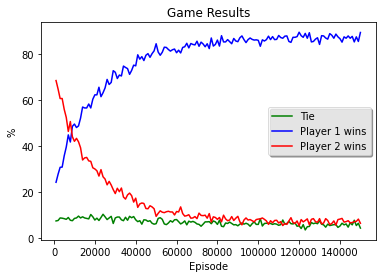

In [ ]:
policy_fileName = "./TicTacToe/DQpolicy_vsSemiRand"
nGames = 150000

p1 = DQPlayer("DQ", tictactoe_dqn_args, isLearning=True)
p2 = SemiRandomPlayer("Random")

log = train(state, p1, p2, nGames=nGames)
plot_log(log)
p1.save_policy(policy_fileName)

The training started out with more wins to the semi-random player obviously, but we can notice the gradual improvement of our player.

Now let's test our player...

In [ ]:
policy_fileName = "./TicTacToe/DQpolicy_vsSemiRand"
p1 = DQPlayer("DQ", tictactoe_dqn_args, isLearning=False)
p1.load_policy(policy_fileName)

p2 = SemiRandomPlayer("Semi-Random")
p3 = MaxminPlayer("Minimax", max_depth=4)
p4 = DQPlayer("DQ2", tictactoe_dqn_args, isLearning=False)
p4.load_policy(policy_fileName)
opponents = [p2, p3, p4]
nGamesList = [10000, 1000, 2]
multi_evaluation(state, p1, opponents, nGamesList)



DQ vs. Semi-Random: P1 Win 94.59% | P2 Win 0.29% | Tie 5.12%
DQ vs. Minimax: P1 Win 0.00% | P2 Win 0.00% | Tie 100.00%
DQ vs. DQ2: P1 Win 0.00% | P2 Win 0.00% | Tie 100.00%


Much better! Our player acieved a fairly good amount of ties against the perfect Minimax, but there is still a fairly significant amount of losses against the random player.  
Notice that this time the "random" evaluation was done against the semi-random player, because it seems more fair.

### Learning against himself (self-play):

Self-play sounds like a promising idea. We let our player just play against itself, so that the first games will actually be similar to playing against a random player, but as the training advances the player also improves and becomes a more challenging opponent against itself.  
A good thing about the experience replay method, is that now we don't actually need to duplicate our player and have it change turns. Instead, we just use the same player to evaluate the Q function, and save the turn in the experience replay buffer. In this way we can learn from the experience of both players from a single game!  
As for implementation, there isn't anything special except for sending ```p1``` twice - for both players.



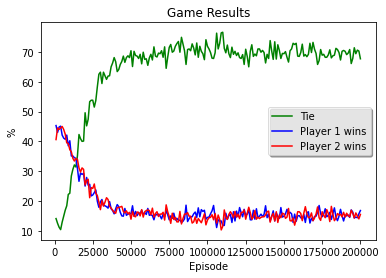

In [ ]:
policy_fileName = "./TicTacToe/DQpolicy_selfPlay"
nGames = 200000

p1 = DQPlayer("DQ", tictactoe_dqn_args, isLearning=True)

log = train(state, p1, p1, nGames=nGames)
plot_log(log)
p1.save_policy(policy_fileName)

Looks intuitively right: both players achieve approximately the same number of wins throught the process (since they are both actually the same player), and as the we progress through the training we see the tie ratio rise.

Now let's test our player...

In [ ]:
policy_fileName = "./TicTacToe/DQpolicy_selfPlay"
p1 = DQPlayer("DQ", tictactoe_dqn_args, isLearning=False)
p1.load_policy(policy_fileName)

p2 = SemiRandomPlayer("Semi-Random")
p3 = MaxminPlayer("Minimax", max_depth=4)
p4 = DQPlayer("DQ2", tictactoe_dqn_args, isLearning=False)
p4.load_policy(policy_fileName)
opponents = [p2, p3, p4]
nGamesList = [10000, 1000, 2]
multi_evaluation(state, p1, opponents, nGamesList)



DQ vs. Semi-Random: P1 Win 92.07% | P2 Win 0.23% | Tie 7.70%
DQ vs. Minimax: P1 Win 0.00% | P2 Win 0.00% | Tie 100.00%
DQ vs. DQ2: P1 Win 0.00% | P2 Win 0.00% | Tie 100.00%


Looks great! 100% ties against the perfect Minimax player, and a very small amount of losses against the semi-random player.

### Learning against another Deep Q-learning player:





Here we'll try to train two DQ players simultaneously. This may be intuitively seen as two human players which both start out without any knowledge of the game, and both try to learn from their own experience of playing against each other.

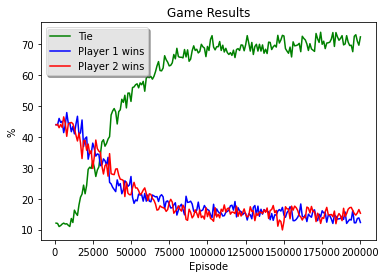

In [ ]:
policy_fileName = "./TicTacToe/DQpolicy_vsQ"
nGames = 200000

p1 = DQPlayer("DQ", tictactoe_dqn_args, isLearning=True)
p2 = DQPlayer("DQ", tictactoe_dqn_args, isLearning=True)

log = train(state, p1, p2, nGames=nGames)
plot_log(log)
p1.save_policy(policy_fileName)

Looks good! Notice how the graph is somewhat similar to that of the self-play, but the convergence is a bit slower. This makes sense because remember that in self-play we actually get twice as much experience for each episode.

Now let's test our player...

In [ ]:
policy_fileName = "./TicTacToe/DQpolicy_vsQ"
p1 = DQPlayer("DQ", tictactoe_dqn_args, isLearning=False)
p1.load_policy(policy_fileName)

p2 = SemiRandomPlayer("Semi-Random")
p3 = MaxminPlayer("Minimax", max_depth=4)
p4 = DQPlayer("DQ2", tictactoe_dqn_args, isLearning=False)
p4.load_policy(policy_fileName)
opponents = [p2, p3, p4]
nGamesList = [10000, 1000, 2]
multi_evaluation(state, p1, opponents, nGamesList)



DQ vs. Semi-Random: P1 Win 92.43% | P2 Win 0.15% | Tie 7.42%
DQ vs. Minimax: P1 Win 0.00% | P2 Win 0.00% | Tie 100.00%
DQ vs. DQ2: P1 Win 0.00% | P2 Win 0.00% | Tie 100.00%


Fantastic! Pretty much identical to the statistics of the self-play training, although slightly better.

### Learning against a perfect Minimax player:

This sort of training is actually a bit cheating, because if we already have a perfect player then there's no need to train a reinforecement learning player to do this task. Anyway, we'll try this out for the sake of the research. 

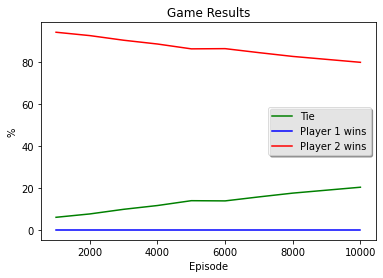

In [ ]:
policy_fileName = "./TicTacToe/DQpolicy_vsMinimax"
nGames = 10000

p1 = DQPlayer("DQ", tictactoe_dqn_args, isLearning=True)
p2 = MaxminPlayer("Minimax", max_depth=4)

log = train(state, p1, p2, nGames=nGames)
plot_log(log)
p1.save_policy(policy_fileName)

Notice that I gave the training only 10,000 games and this took 45 minutes. This is because the Minimax player is fairly slow. This also prevents us from performing enough learning episodes, because if for example we'd like to train for 100,000 episoded then it would take about 7.5 hours!  Though it does look like the training is stable and our player improves the amount of ties.

Now let's test our player...



In [ ]:
policy_fileName = "./TicTacToe/DQpolicy_vsMinimax"
p1 = DQPlayer("DQ", tictactoe_dqn_args, isLearning=False)
p1.load_policy(policy_fileName)

p2 = SemiRandomPlayer("Semi-Random")
p3 = MaxminPlayer("Minimax", max_depth=4)
p4 = DQPlayer("DQ2", tictactoe_dqn_args, isLearning=False)
p4.load_policy(policy_fileName)
opponents = [p2, p3, p4]
nGamesList = [10000, 1000, 2]
multi_evaluation(state, p1, opponents, nGamesList)



DQ vs. Semi-Random: P1 Win 38.74% | P2 Win 32.19% | Tie 29.07%
DQ vs. Minimax: P1 Win 0.00% | P2 Win 50.00% | Tie 50.00%
DQ vs. DQ2: P1 Win 0.00% | P2 Win 0.00% | Tie 100.00%


Our player did actually manage to tie half of the games against the perfect Minimax player, but also failed against the semi-random player. We may describe this in two possible reasons:
- Not enough learning episodes, as explained before. I don't believe this is the main reason because we saw that our player did manage to tie against the Minimax player.
- The Minimax player only takes a move which it believes is best when assuming its opponent is also perfect. As a result, our learning player only sees a subset of the entire state space, never encounters some of the states, and thus never learns how to act in these states. So playing against the random player sometimes results in these states, in which our player fails to deal with.

---
## **Conclusion**
We saw that deep Q-learning is a good method for performing Q-learning in a function approximation setting when a tabular setting isn't feasible.
We examined 5 types of training: random, semi-random, self-play, two learning players, and perfect Minimax opponent. The method with the best results was  self-play, which achieved really good results in the evaluation. Not perfect like the tabular Q-learning player, but pretty decent.  
It is also notable that the self-play method doesn't require us to program another player with a heuristic, and only learns from experience. This is a desired property because for more advance games programming and coming up with such heuristics may be really difficult.

---
## **Let's play!**

In this section you can try yourself to play against each of the players:  
- ```RandomPlayer(name)``` - A random player.
- ```SemiRandomPlayer(name)``` - A semi-random player, which acts randomly unless given the opportunity to win the game in the next turn.
- ```MaxminPlayer(name, depth)``` - A minimax player which checks `depth` steps forward and uses some heuristic to take the best resulting action. For `depth = 9` this player will be perfect (but pretty slow) since this is the maximal depth of a TicTacToe game.
- ```DQPlayer(name, tictactoe_dqn_args, isLearning=False)``` - Our trained Deep Q-learning player with a policy loaded by `load_policy(policy_fileName)`.
- ```HumanPlayer(name)``` - Another human, play against a friend.  

Good luck!



In [ ]:
policy_fileName = "./TicTacToe/DQpolicy_selfPlay"
p1 = HumanPlayer("Player")
p2 = DQPlayer("DQ", tictactoe_dqn_args, isLearning=False)
p2.load_policy(policy_fileName)
game = Game(state, p1, p2)
game.play()
game.reset()

############################################################################################
Tic Tac Toe
############################################################################################
-------------
|   |   |   |
|   |   |   |
|   |   |   |
-------------
Player: Enter desired cell as [row col]:
0 0
-------------
| x |   |   |
|   |   |   |
|   |   |   |
-------------
-------------
| x |   |   |
|   | o |   |
|   |   |   |
-------------
Player: Enter desired cell as [row col]:
1 1
Player: Enter desired cell as [row col]:
2 2
-------------
| x |   |   |
|   | o |   |
|   |   | x |
-------------
-------------
| x |   |   |
|   | o | o |
|   |   | x |
-------------
Player: Enter desired cell as [row col]:
1 0
-------------
| x |   |   |
| x | o | o |
|   |   | x |
-------------
-------------
| x |   |   |
| x | o | o |
| o |   | x |
-------------
Player: Enter desired cell as [row col]:
0 2
-------------
| x |   | x |
| x | o | o |
| o |   | x |
-------------
-------------
| x